In [1]:
device = 'cuda'

## Import Packages

In [2]:
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.distributions.kl import kl_divergence
from torchvision import datasets, transforms
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from tqdm import tqdm
import time

In [3]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())

## Download and preprocess the Data

In [4]:
transform=transforms.Compose([
    transforms.ToTensor(),
])

mnist_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)

train_dataloader = DataLoader(mnist_dataset, shuffle=True, batch_size=1024)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 898193.58it/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134113.75it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1268905.47it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4500479.27it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Create Model

We input a noise vector z which sampled from Normal distribution,  N(0, 1), then the Encoder outputs mean and standard deviation which will be used to build a new latent space(distribution). Then we will sample random noise vector from this distribution and use it as input to the Decoder, and Decoder will create image with this.

In [5]:
class Encoder(nn.Module):
  def __init__(self, image_channel=1, output_channel=32, hidden_dim=16):
    super(Encoder, self).__init__()
    self.z_dim = output_channel
    self.enc_layers = nn.Sequential(
        # (N, 1, 28, 28)
        self.make_enc_block(image_channel, hidden_dim),
        # (N, 16, 13, 13)
        self.make_enc_block(hidden_dim, hidden_dim*2),
        # (N, 32, 5, 5)
        self.make_enc_block(hidden_dim * 2, output_channel * 2, final_layer=True),
        # (N, 64, 1, 1)
    )

  def make_enc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
    if final_layer:
      return nn.Sequential(
          nn.Conv2d(input_channels, output_channels, kernel_size, stride)
      )
    else:
      return nn.Sequential(
          nn.Conv2d(input_channels, output_channels, kernel_size, stride),
          nn.BatchNorm2d(output_channels),
          nn.LeakyReLU(0.2, inplace=True)
      )

  def forward(self, image):
    '''
    Input:
      image: (N, 1, 28, 28)
    Output:
      (mean) encoding[:, :self.z_dim]: (N, 32)
      (standard deviation) encoding[:, self.z_dim].exp(): (N, 32)
    '''
    enc_pred = self.enc_layers(image) # enc_pred: (N, 64, 1, 1)
    encoding = enc_pred.view(len(enc_pred), -1)  # encoding: (N, 64)
    return encoding[:, :self.z_dim], encoding[:, self.z_dim:].exp()

In [6]:
class Decoder(nn.Module):
  def __init__(self, z_dim=32, image_channel=1, hidden_dim=64):
    super(Decoder, self).__init__()
    self.z_dim = z_dim
    self.dec_layers = nn.Sequential(
        # (N, 32, 1, 1)
        self.make_dec_block(z_dim, hidden_dim*4),
        # (N, hidden_dim*4, 3, 3)
        self.make_dec_block(hidden_dim*4, hidden_dim *2, kernel_size=4, stride=1),
        # (N, hidden_dim *2, 6, 6)
        self.make_dec_block(hidden_dim*2, hidden_dim),
        # (N, hidden_dim, 13, 13)
        self.make_dec_block(hidden_dim, image_channel, kernel_size=4, final_layer=True)
        # (N, image_channel, 28, 28)
    )

  def make_dec_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
    if final_layer:
      return nn.Sequential(
          nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
          nn.Sigmoid()
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
          nn.BatchNorm2d(output_channels),
          nn.ReLU(inplace=True)
      )

  def forward(self, noise):
    """
    Input:
      noise: (N, 32)

    """
    x = noise.view(len(noise), self.z_dim, 1, 1) # (N, 32, 1, 1)
    return self.dec_layers(x)

In [7]:
class VAE(nn.Module):
  def __init__(self, z_dim=32, image_channel=1, hidden_dim=64):
    super(VAE, self).__init__()
    self.z_dim = z_dim
    self.encode = Encoder(image_channel, z_dim)
    self.decode = Decoder(z_dim, image_channel)

  def forward(self, images):
    # get mean and standard deviation from encoder
    q_mean, q_stddev = self.encode(images)
    # create new distribution from mean and standard deviation we got
    q_dist = Normal(q_mean, q_stddev)
    # randomly smaple noise vectors from distribution we created
    z_sample = q_dist.rsample() # (N, 32)
    fake_images = self.decode(z_sample)
    return fake_images, q_dist

In [8]:
vae = VAE().to(device)

## Training

In [9]:
reconstruction_loss = nn.BCELoss(reduction='sum')

def kl_divergence_loss(q_dist):

    return kl_divergence(q_dist, Normal(torch.zeros_like(q_dist.mean), torch.ones_like(q_dist.stddev))).sum(-1)

In [10]:
plt.rcParams["figure.figsize"] = (16, 8)
vae_opt = torch.optim.Adam(vae.parameters(), lr=0.002)

Epoch: 0


100%|██████████| 59/59 [00:10<00:00,  5.63it/s]


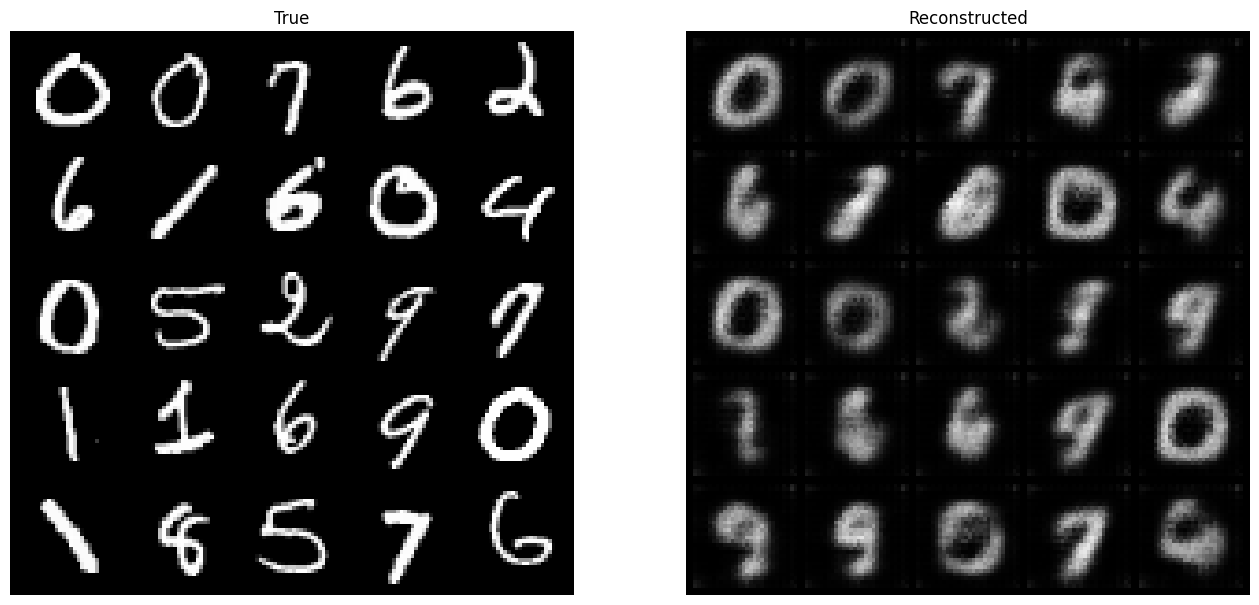

Epoch: 1


100%|██████████| 59/59 [00:09<00:00,  6.28it/s]


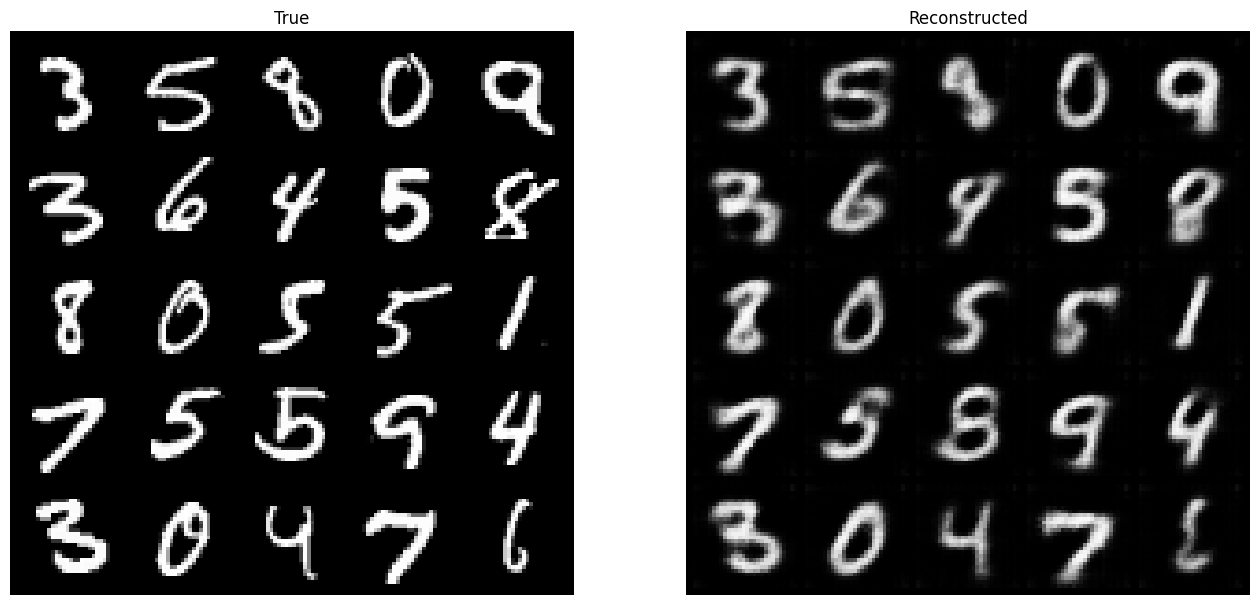

Epoch: 2


100%|██████████| 59/59 [00:08<00:00,  6.56it/s]


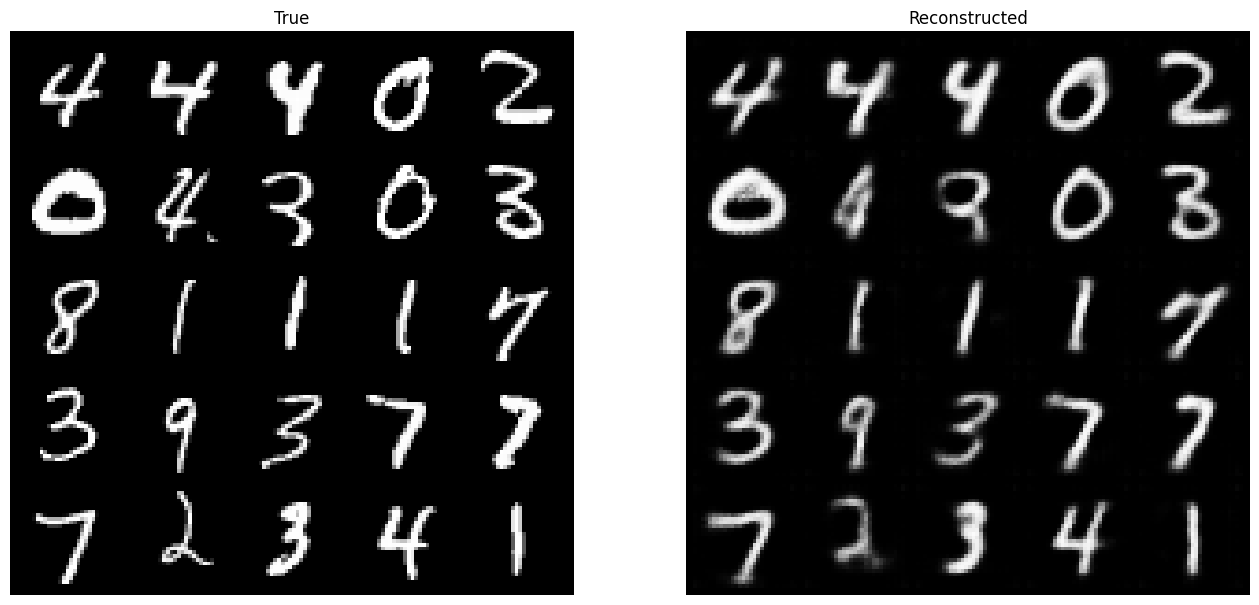

Epoch: 3


100%|██████████| 59/59 [00:08<00:00,  7.19it/s]


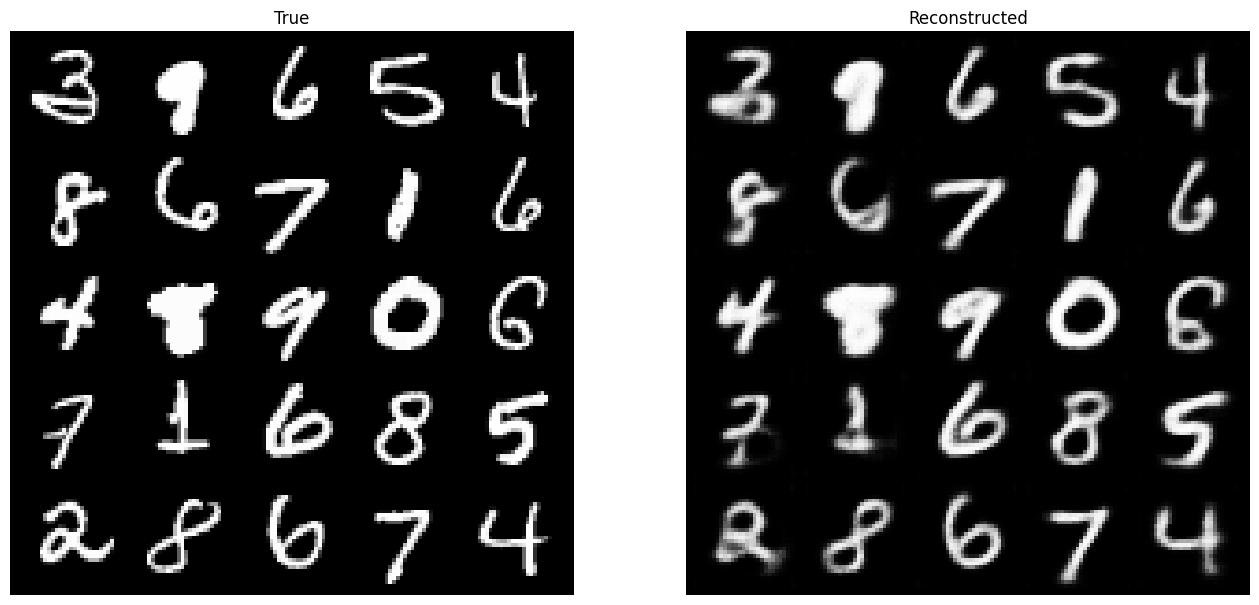

Epoch: 4


100%|██████████| 59/59 [00:08<00:00,  6.86it/s]


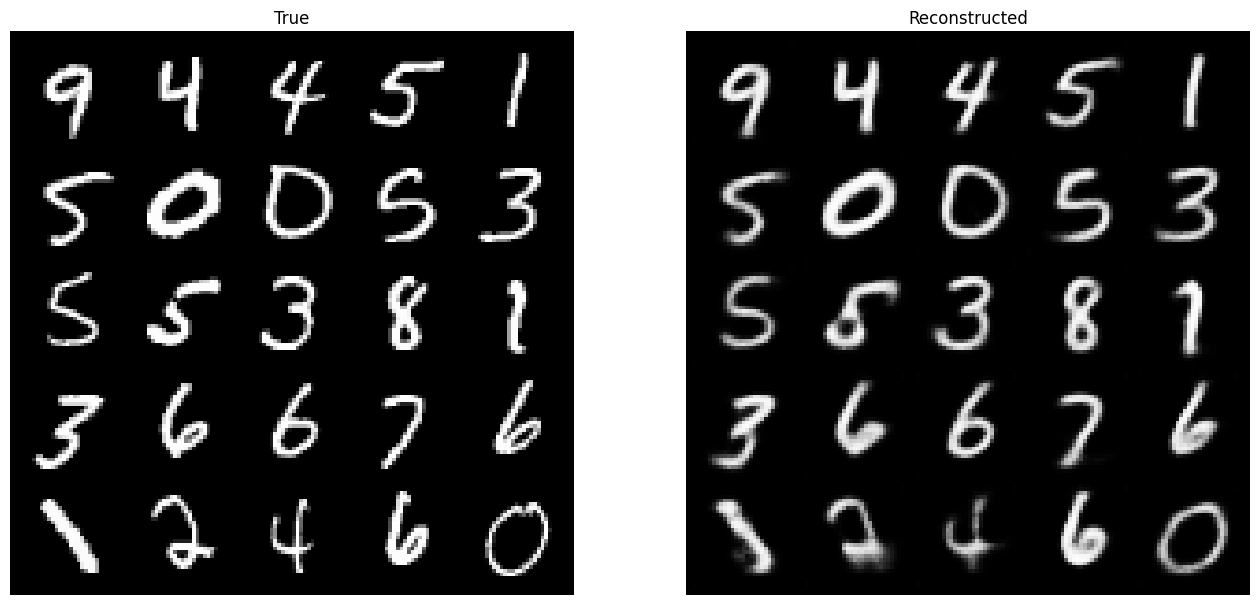

Epoch: 5


100%|██████████| 59/59 [00:08<00:00,  6.72it/s]


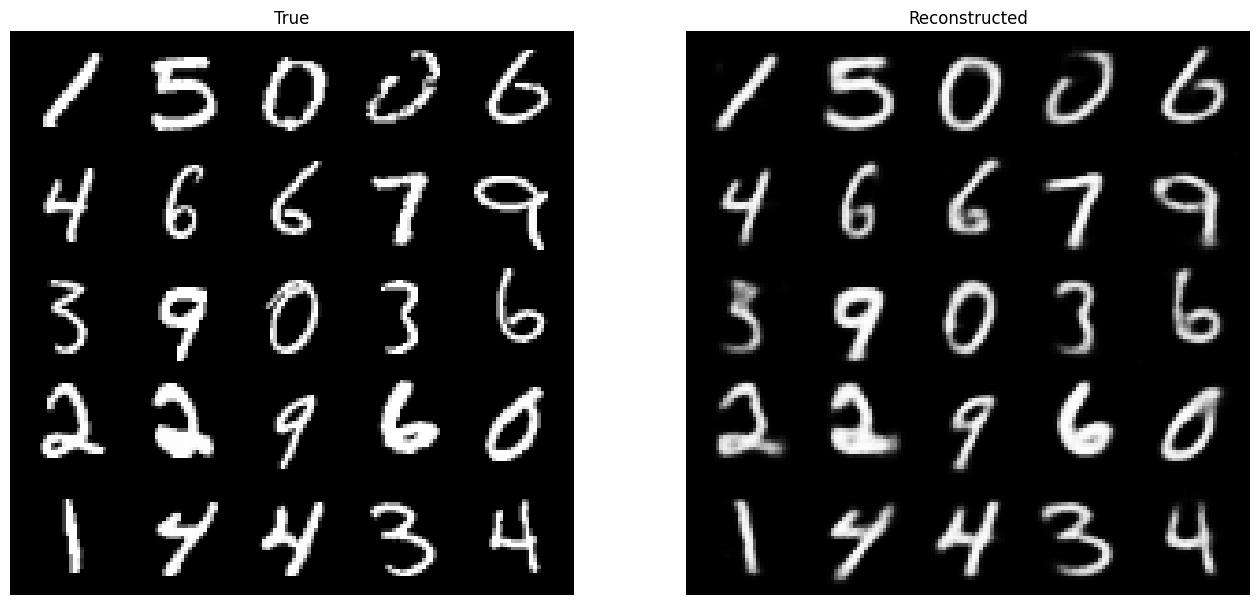

Epoch: 6


100%|██████████| 59/59 [00:08<00:00,  7.22it/s]


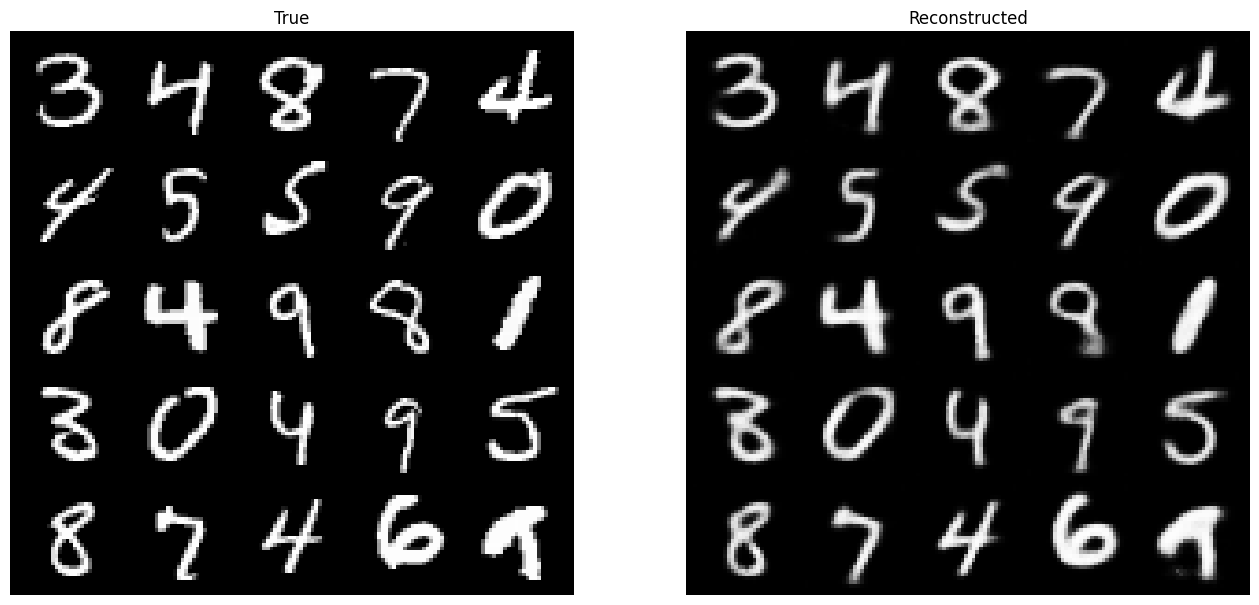

Epoch: 7


100%|██████████| 59/59 [00:07<00:00,  7.53it/s]


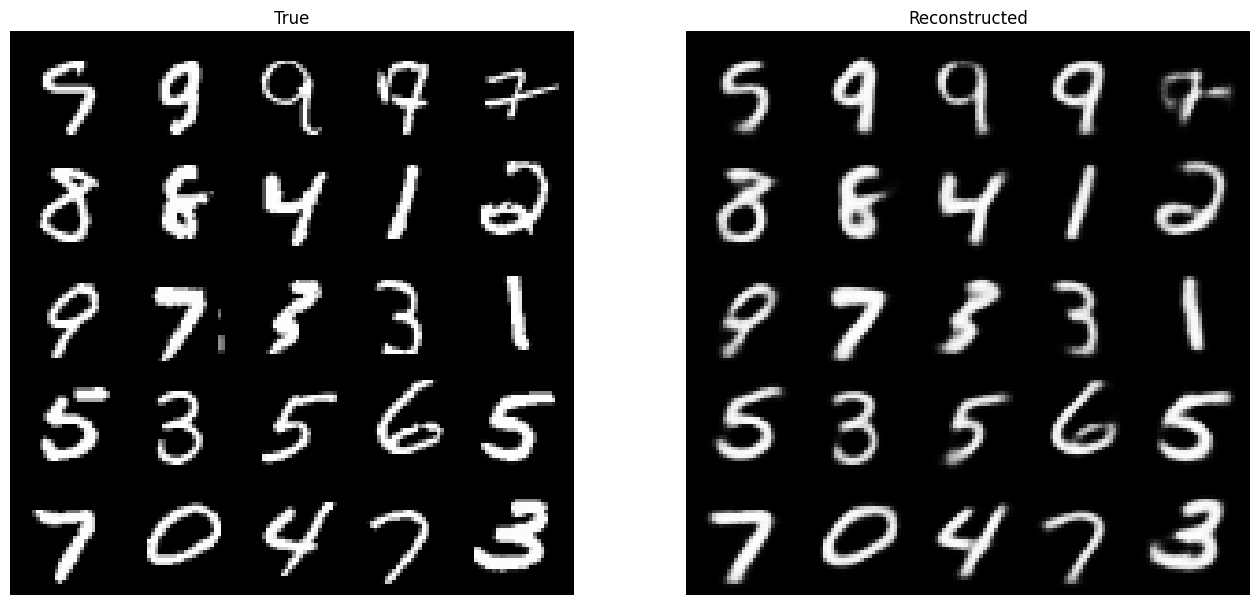

Epoch: 8


100%|██████████| 59/59 [00:08<00:00,  6.81it/s]


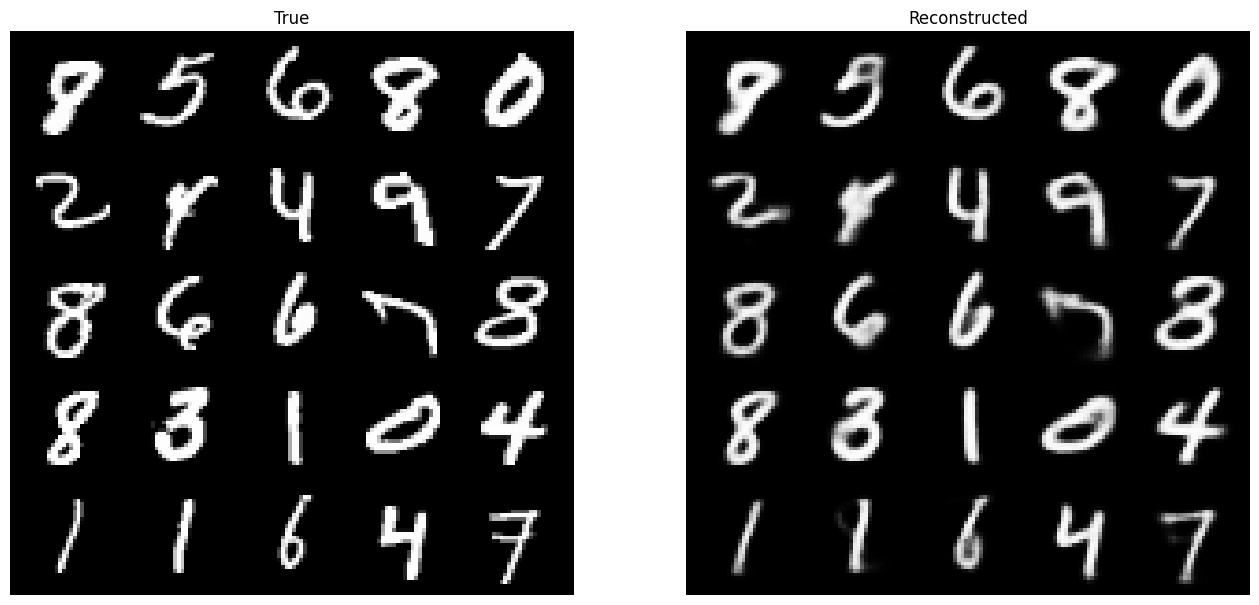

Epoch: 9


100%|██████████| 59/59 [00:08<00:00,  6.83it/s]


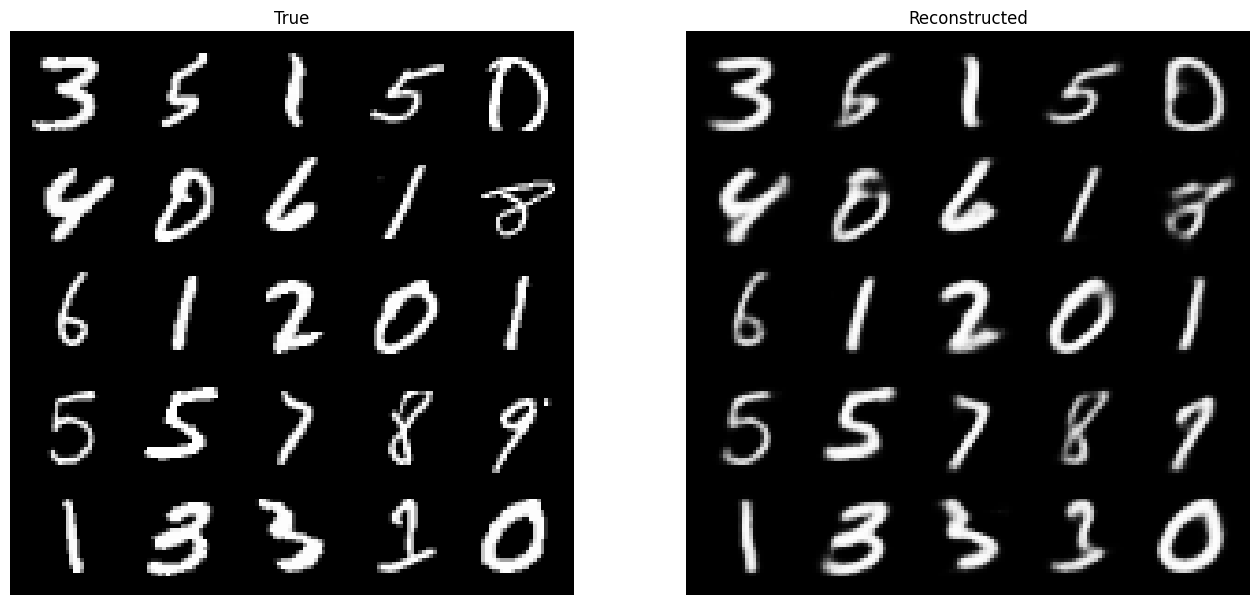

In [11]:
for epoch in range(10):
  print(f"Epoch: {epoch}")
  time.sleep(0.5)
  for images, _ in tqdm(train_dataloader):
    images = images.to(device)
    vae_opt.zero_grad()
    fake_images, poster_distribution = vae(images)
    loss = reconstruction_loss(fake_images, images) + kl_divergence_loss(poster_distribution).sum()
    loss.backward()
    vae_opt.step()
  plt.subplot(1,2,1)
  show_tensor_images(images)
  plt.title("True")
  plt.subplot(1,2,2)
  show_tensor_images(fake_images)
  plt.title("Reconstructed")
  plt.show()